In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from tomo_encoders.misc_utils.feature_maps_vis import view_midplanes
import cupy as cp
import time
import h5py
# sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/tomo_encoders/tasks/sparse_segmenter/')
from tomo_encoders.tasks.sparse_segmenter.recon import fbp_filter, recon_patches_3d, recon_binning
from tomo_encoders import DataFile, Patches
from tomo_encoders.tasks.sparse_segmenter.sparse_segmenter import SparseSegmenter
import os
import signal
# import tomocg as pt

In [5]:
# # Use managed memory
# cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc)

### Read projections data  

In [6]:
filename = 'mli_L206_HT_650_L3'
projs_path = '/data02/MyArchive/AM_part_Xuan/projs' 
binning = 1 
ntheta = 3000

In [7]:
read_fpath = os.path.join(projs_path, filename + '_projs_bin%i_ntheta%i.hdf5'%(binning,ntheta))
with h5py.File(read_fpath, 'r') as hf:
    projs = np.asarray(hf['data'][:])
    theta = np.asarray(hf['theta'][:])
    center = projs.shape[2]/2#float(np.asarray(hf['center'][()]))

In [8]:
projs.shape

(3000, 1102, 4200)

In [9]:
center

2100.0

In [10]:
theta_binning = 6
yx_binning = 4
t0 = time.time()
vol_binned = recon_binning(projs, theta, center, theta_binning, yx_binning, apply_fbp = True)
t1 = time.time()
print("binned reconstruction time: ", t1-t0)

/home/atekawade/anaconda3/envs/tf2GPU/lib/python3.7/site-packages/cupy/fft/_fft.py:152: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()


(500, 276, 1576)
0.8767533302307129
total bytes 2667267072
binned reconstruction time:  2.9765093326568604


array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

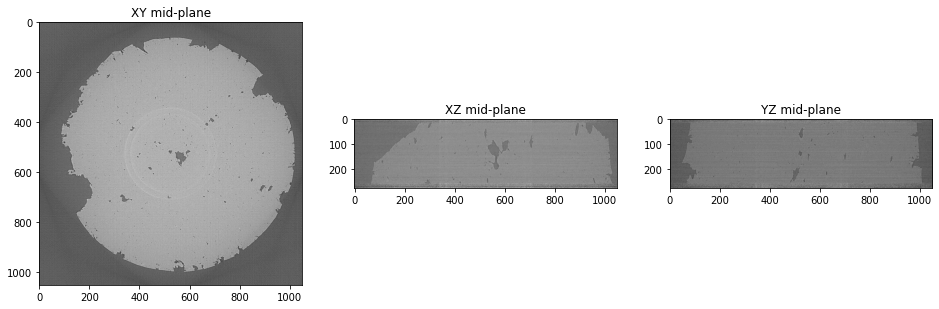

In [11]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
view_midplanes(vol_binned, ax = ax)

## Segment the binned volume  

In [9]:
type(vol_binned)

numpy.ndarray

In [10]:
bin_size = (64,64,64)
descriptor_tag = 'test_noblanks_pt2cutoff_nostd'
model_names = {"segmenter" : "segmenter_Unet_%s"%descriptor_tag}
model_path = '/data02/MyArchive/aisteer_3Dencoders/models/AM_part_segmenter'

In [11]:
fe = SparseSegmenter(model_initialization = 'load-model', \
                     model_names = model_names, model_path = model_path)

In [12]:
patches = Patches(vol_binned.shape, initialize_by = "grid", \
                  patch_size = fe.model_size, stride = 1)
Yp_binned = np.zeros(vol_binned.shape, dtype = np.uint8)

In [13]:
# Yp_binned = fe._segment_patches_fast(vol_binned, Yp_binned, patches, arr_split_infer=32, workers = 1)

In [14]:
Yp_binned = fe._segment_patches(vol_binned, Yp_binned, patches, batch_size = 64)

time for extracting 1445 patches:  0.4131035804748535
Done 23 of 1445, slice is slice(1408, 1445, None)
time for predicting on patches:  73.3172824382782
Total time for segmentation: 73.88 seconds


array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

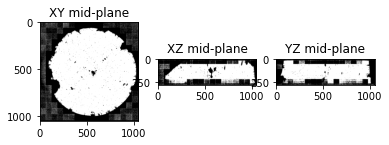

In [15]:
view_midplanes(vol = Yp_binned)

In [16]:
5%2

1

In [17]:
1445/32

45.15625